# Outliers and imputation

The first step in preparing the data for analysis concerns **outliers and missing values**. Outliers are data samples that are so different from the remaining that they can skew your analysis if not removed from the dataset. Missing values are values that for some reason have not been informed for given features of given samples. Aside from the missing information they would provide, scikit-learn estimators generally expect your `DataFrame` to be complete.

To understand the resources provided by scikit-learn for this step, we'll use the New York City AirBnb dataset available at Kaggle. To download it, follow the [first stage of this tutorial](https://medium.com/@yvettewu.dw/tutorial-kaggle-api-google-colaboratory-1a054a382de0), which shows how to download access credentials for Kaggle (`kaggle.json`). Once you have downloaded the credentials, use the side menu to upload the file to Colab, and run the cells below:

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [2]:
!mkdir /root/.kaggle
!cp /content/kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


> In this case, since the dataset is not the only file in the zip file, we first have to unzip everything before loading the dataset:

In [4]:
!unzip new-york-city-airbnb-open-data.zip

Archive:  new-york-city-airbnb-open-data.zip
replace AB_NYC_2019.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace New_York_City_.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


> Should any of the cells above fail, contact the maintainers of scikit-zero ;)

Let's take a peek into the dataset:

In [5]:
nyc_airbnb = pd.read_csv("AB_NYC_2019.csv")
nyc_airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [6]:
nyc_airbnb.shape

(48895, 16)

Note that now we have a much larger number of samples than in the iris dataset we used previously. Regarding the number of features, this dataset is actually small for real-world standards, but will help keep our notebook simple. Let's start dropping some features which won't help in our analysis.

> `last_review` is a `datetime` field, which we could use for time series analysis. However, to make this notebook simple we're gonna discard it.

In [7]:
discard = ["id", "last_review"]

In [8]:
X = nyc_airbnb.drop(discard, axis=1)

Before moving on to the specific topics of this analysis, let's review the basics on missing values. We can check them as follows:

In [9]:
X.isna().sum()

name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In the case of features where very few samples have missing values, it's often safe to discard those samples. We can do that using the `dropna()` method, and specifying that we only want to drop samples for which the given subset of features present missing values (`subset=["name", "host_name"]`):

In [10]:
X = X.dropna(subset=["name", "host_name"])

In [11]:
X.isna().sum()

name                                  0
host_id                               0
host_name                             0
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10037
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [12]:
X.shape

(48858, 14)

## Detecting outliers

The very first step into data preparation is detecting and removing outliers from the data. To do that, we have to select which features we'll consider for this analysis, and in general they will be numerical. Looking at the feature distributions, we'll go with the following:

In [13]:
numerical = ["price", "minimum_nights","number_of_reviews", 
             "calculated_host_listings_count", "availability_365"]

Since these features all follow an exponential distribution, we'll start by transforming them using a logarithmic transformation:

> Check [pandas-zero](https://github.com/leobezerra/pandas-zero) if you missed that episode ;)

In [14]:
import numpy as np

In [15]:
X.loc[:,numerical] = X[numerical].apply(np.log1p, axis=1)

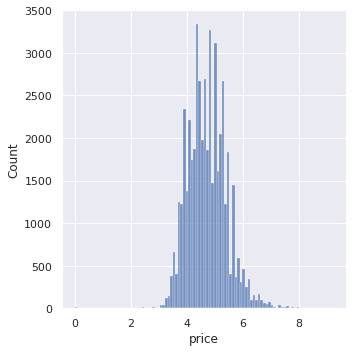

In [16]:
sns.displot(X["price"], bins=100)

Note that now the numerical features we selected follow a distribution that is more similar to a normal distribution. The next step is selecting an unsupervised learning algorithm to cluster the data and identify the samples that do not belong to that big cluster. Scikit-learn offers a few options, and here we're gonna take **local outlier factor** (LOF) as an example:

In [17]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor()

Let's isolate the numerical features to easen our task:

> Since the index of the data is preserved, we'll be able to apply the insights obtained from X_num to X later ;)

In [18]:
X_num = X[numerical]

In the context of outlier detection, we use the `fit_predict()` method directly on the input features, without having a target feature `y` to predict. The predicted values will either be 1 (an inlier) or -1 (an outlier), according to the internal model produced by LOF. Since the output is provided as a numpy array, we wrap it as a Pandas `Series` and specify that we want to preserve the index from `X_num`:

In [19]:
predicted = pd.Series(clf.fit_predict(X_num), name="predicted", index=X_num.index)

Now we can concatenate the `X_num` dataframe with the predicted labels, and query those who were identified as outliers:

In [20]:
X_predicted = pd.concat([X_num, predicted], axis=1)
X_predicted.head()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,predicted
0,5.010635,0.693147,2.302585,1.945910,5.902633,1
1,5.420535,0.693147,3.828641,1.098612,5.874931,1
2,5.017280,1.386294,0.000000,0.693147,5.902633,1
3,4.499810,0.693147,5.602119,0.693147,5.273000,1
4,4.394449,2.397895,2.302585,0.693147,0.000000,1


In [21]:
X_outliers = X_predicted.query("predicted == -1")
X_outliers.head()

,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,predicted
85,6.685861,0.693147,3.258097,0.693147,2.079442,-1
106,4.836282,4.510860,5.093750,1.098612,4.927254,-1
113,4.795791,3.433987,6.148468,1.098612,5.262690,-1
116,5.786897,1.386294,5.783825,0.693147,4.682131,-1
193,4.875197,2.708050,0.000000,1.098612,0.000000,-1


In [22]:
X_outliers.shape

(1753, 6)

Since we have preserved the index, we can use them to drop the samples in `X` that LOF indicated as outliers:

In [23]:
X = X.drop(X_predicted.query("predicted == -1").index)
X.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,5.010635,0.693147,2.302585,0.21,1.945910,5.902633
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,5.420535,0.693147,3.828641,0.38,1.098612,5.874931
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,5.017280,1.386294,0.000000,NaN,0.693147,5.902633
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,4.499810,0.693147,5.602119,4.64,0.693147,5.273000
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,4.394449,2.397895,2.302585,0.10,0.693147,0.000000


In [24]:
X.shape

(47105, 14)

## Imputing missing values

Missing values can compromise the ability of an estimator, particularly the ones in scikit-learn. As we've done previously, sometimes it makes sense to drop samples or even whole features when the proportion of missing values allows that:

* if only a few samples present missing values for a given feature, the samples could likely be discarded.
* when almost all samples present missing values for a given feature, the feature could likely be discarded.

When none of the conditions above apply, the typical approach is to **impute** data, i.e., to produce artificial values based on the available data. The types of imputation methods vary as to the nature of the data used, as we discuss next.

### Based solely on the given feature

The simplest imputation approach is to fill values of a given feature based only on the values available for that feature from the remaining samples of the dataset. This is provided by scikit-learn as the `SimpleImputer` preprocessor, which fills missing values with the feature mean, by default:

In [25]:
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer()

Since we're only interested in imputing the `reviews_per_month` feature, we'll use the `make_column_transformer` method from the `compose` module. This method allows us to specify preprocessing approaches for specific features.

- Let's understand the code below:
```python 
mean_transformer = make_column_transformer(
                                             (mean_imputer, ["reviews_per_month"]),
                                             remainder="drop"
                                            )
```
- Creates the column transformer, specifying that `mean_imputer` should be applied to `["reviews_per_month"]`, and that the remainder of the features should be dropped. 

In [26]:
from sklearn.compose import make_column_transformer
mean_transformer = make_column_transformer(
                                           (mean_imputer, ["reviews_per_month"]),
                                           remainder="drop"
                                           )

Once we have the transformer ready, we can use its `fit_transform()` method to impute the data, wrapping it in a Pandas `DataFrame` where we preserve the index from the original data for when we want to replace the original missing values. 

In [27]:
X_mean = pd.DataFrame(mean_transformer.fit_transform(X), columns=["reviews_per_month"], index=X.index)
X_mean.head()

,reviews_per_month
0,0.210000
1,0.380000
2,1.391274
3,4.640000
4,0.100000


In [28]:
X_mean.isna().sum()

reviews_per_month    0
dtype: int64

As we can see, every missing value has been replaced. Let's compare this distribution of this feature before and after imputation:

(0.0, 10.0)

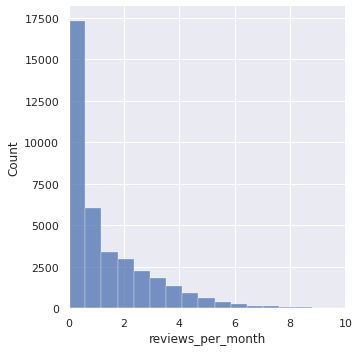

In [29]:
sns.displot(X["reviews_per_month"], bins=100)
plt.xlim(0, 10)

Note: plt.xlim only decreases the x-axis scale to improve data visualization. However, because it is a long tail distribution, there are samples with a higher value of reviews_per_month.

(0.0, 10.0)

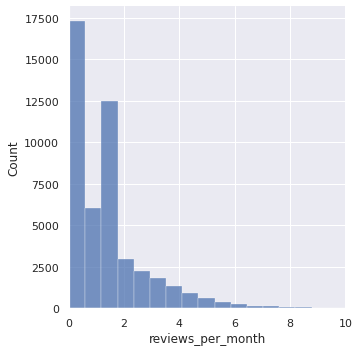

In [30]:
sns.displot(X_mean["reviews_per_month"], bins=100)
plt.xlim(0, 10)

The different approaches for `SimpleImputer` are meant to help the user find a strategy that impact less the data distribution. For instance, we could have tried replacing the missing values with the mode:

(0.0, 10.0)

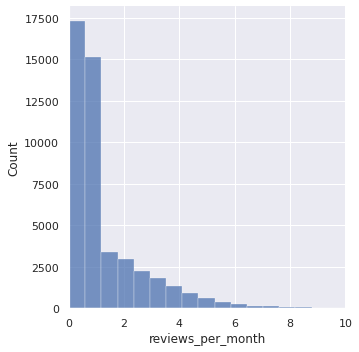

In [31]:
mode_imputer = SimpleImputer(strategy="most_frequent")
mode_transformer = make_column_transformer(
                                           (mode_imputer, ["reviews_per_month"]),
                                           remainder="drop"
                                           )
X_mode = pd.DataFrame(mode_transformer.fit_transform(X), columns=["reviews_per_month"], index=X.index)
sns.displot(X_mode["reviews_per_month"], bins=100)
plt.xlim(0, 10)

Notice that, in this case, the imputed feature distribution is very similar whether the mean or mode has been used, but that may not always be the case.

### Based on multiple features

A more robust approach to data imputation is determining artificial values based on multiple features (preferably, the whole dataset). In the example below, we're gonna use the numerical features to aid us impute the missing values for `reviews_per_month`:

In [32]:
from sklearn.impute import KNNImputer
knn_imputer = KNNImputer()

Let's isolate the numerical features once again, this time including the feature we want to impute:

In [33]:
numerical = ["price", "minimum_nights","number_of_reviews", "reviews_per_month",
             "calculated_host_listings_count", "availability_365"]
X_num = X[numerical]

Imputing is performed the same way using `fit_transform()`, wrapping the result in a `DataFrame` and preserving column and index information:

> Note that the cell below takes a little longer to run, because a kNN model is fit internally.

In [34]:
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X_num), columns=X_num.columns, index=X_num.index)
X_imputed.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,5.010635,0.693147,2.302585,0.210,1.945910,5.902633
1,5.420535,0.693147,3.828641,0.380,1.098612,5.874931
2,5.017280,1.386294,0.000000,0.436,0.693147,5.902633
3,4.499810,0.693147,5.602119,4.640,0.693147,5.273000
4,4.394449,2.397895,2.302585,0.100,0.693147,0.000000


In [35]:
X_imputed.isna().sum()

price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Let's compare the data distribution before and after imputation:

(0.0, 10.0)

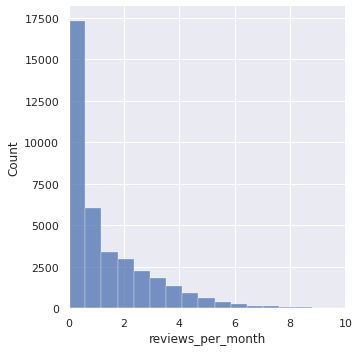

In [36]:
sns.displot(X["reviews_per_month"], bins=100)
plt.xlim(0, 10)

(0.0, 10.0)

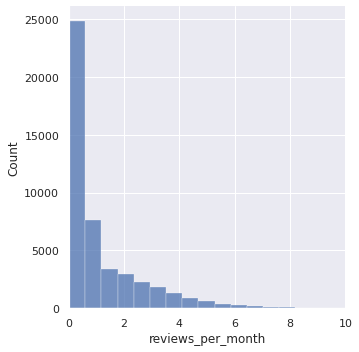

In [37]:
sns.displot(X_imputed["reviews_per_month"], bins=100)
plt.xlim(0, 10)

As we can see, the imputed version is now much more similar to the original data distribution. 